In [1]:
import json
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from pathlib import Path
import pprint
import matplotlib.pyplot as plt
from dataclasses import asdict
import numpy as np
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import jax
import jax.numpy as jnp
# sns.set()
import orbax.checkpoint

from meta_transformer.data import load_batches
from meta_transformer import utils, preprocessing, output_dir
from meta_transformer.meta_model import MetaModelClassifier
from backdoors import paths


figdir = "../../writeups/iclr-2023/figures/"

### Detecting backdoors

In [2]:
# - plot ROC curve for each poison type
# - plot ROC curves for OOD test sets
# - compare AUROC to baseline (meta neural analysis and universal litmus patterns)

CHUNK_SIZE = 128
NUM_SAMPLES = 500
POISON_TYPES = [
    "random_border_pos_pattern",
    "single_pixel",
    "random_noise",
    "center_pattern_ood",
    "ulp_test_ood",
    "simple_pattern_ood",  # not really OOD
]


def normalize(x):
    return (x + 0.242) / 3.14


def _load_data(path):
    data = load_batches(path, max_datapoints=NUM_SAMPLES)
    if not len(data) == NUM_SAMPLES:
        print(f"WARNING: only {len(data)} samples loaded from {path}.")
    return utils.tree_stack([x["params"] for x in data])


@jax.jit
def _process_base_models(params):
    flat = jax.vmap(
        lambda p: preprocessing.chunk(p, CHUNK_SIZE)[0]
        )(params)
    return normalize(flat)


def load_base_models(path):
    data = _load_data(path)
    return _process_base_models(data)

In [3]:
clean = load_base_models(paths.TEST_CLEAN / "clean_0")

backdoored = {}
for p in POISON_TYPES:
    if p.endswith("_ood"):
        ood_data_path = paths.PRIMARY_BACKDOOR / p[:-4]
        backdoored[p] = load_base_models(ood_data_path)
    else:
        backdoored[p] = load_base_models(paths.TEST_BACKDOOR / p)

In [4]:
clean.shape

(100, 572, 128)

In [5]:
backdoored["center_pattern_ood"].shape

(500, 572, 128)

In [6]:
checkpointer = orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler())
hpc_checkpoint_dir = output_dir + "/hpc-mm-checkpoints"
local_checkpoint_dir = "/home/lauro/projects/meta-models/meta-transformer/outputs/mm-checkpoints"
checkpoint_dirs = {
    "random_border_pos_pattern": hpc_checkpoint_dir + "/random_border_pos_pattern",
    "center_pattern_ood": hpc_checkpoint_dir + "/random_border_pos_pattern",
    "ulp_test_ood": hpc_checkpoint_dir + "/random_border_pos_pattern",
    "simple_pattern_ood": hpc_checkpoint_dir + "/random_border_pos_pattern",
    "single_pixel": local_checkpoint_dir + "/single_pixel",
    "random_noise": local_checkpoint_dir + "/random_noise",
}

run_names = {
    "random_border_pos_pattern": "run_1695834256",
    "center_pattern_ood": "run_1695834256",
    "ulp_test_ood": "run_1695834256",
    "simple_pattern_ood": "run_1695834256",
    "single_pixel": "run_1695862808",
    "random_noise": "run_1695874903",
}

assert len(checkpoint_dirs) == len(run_names) == len(POISON_TYPES)


def restore_mm(poison_type):
    dir_path, run_name = checkpoint_dirs[poison_type], run_names[poison_type]
    print(f"Restoring from {dir_path}")
    params = checkpointer.restore(os.path.join(dir_path, run_name))
    with open(os.path.join(dir_path, "info.json")) as f:
        info = json.load(f)

    assert info["chunk_size"] == CHUNK_SIZE
    model_config = info["model_config"]
    model = MetaModelClassifier(**model_config)
    return model, params

In [7]:
def get_rates(poison_type):
    """Get false positive and true positive rates for a range of thresholds."""
    model, params = restore_mm(poison_type)
    logits_on_clean, _ = model.apply({"params": params}, clean)
    logits_on_backdoored, _ = model.apply({"params": params}, backdoored[poison_type])
    
    all_logits = np.concatenate([logits_on_clean, logits_on_backdoored])
    tmin, tmax = all_logits.min(), all_logits.max()
    print("clean logits range:", logits_on_clean.min(), logits_on_clean.max())
    print("backdoored logits range:", logits_on_backdoored.min(), logits_on_backdoored.max())

    thresholds = np.arange(tmin, tmax, 0.05)
    fpr = {}
    tpr = {}
    for t in thresholds:
        fpr[t] = np.mean((logits_on_clean > t) == 1)
        tpr[t] = np.mean((logits_on_backdoored > t) == 1)
    return fpr, tpr

Restoring from /home/lauro/projects/meta-models/meta-transformer/outputs/hpc-mm-checkpoints/random_border_pos_pattern


2023-09-28 13:32:08.902736: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 499.24MiB (rounded to 523494400)requested by op 
2023-09-28 13:32:08.902841: W external/tsl/tsl/framework/bfc_allocator.cc:497] ******************_________**************************___________*****************x*************x***_
2023-09-28 13:32:08.902884: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2593] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 523494400 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  499.24MiB
              constant allocation:         0B
        maybe_live_out allocation:  499.24MiB
     preallocated temp allocation:         0B
                 total allocation:  998.49MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 499.24MiB
		Entry Parameter Subshape: f32[100,4,572,572]

	Buffe

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 523494400 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  499.24MiB
              constant allocation:         0B
        maybe_live_out allocation:  499.24MiB
     preallocated temp allocation:         0B
                 total allocation:  998.49MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 499.24MiB
		Entry Parameter Subshape: f32[100,4,572,572]
		==========================

	Buffer 2:
		Size: 499.24MiB
		Operator: op_name="jit(<lambda>)/jit(main)/exp" source_file="/home/lauro/projects/meta-models/meta-transformer/meta_transformer/attention.py" source_line=83
		XLA Label: exponential
		Shape: f32[100,4,572,572]
		==========================



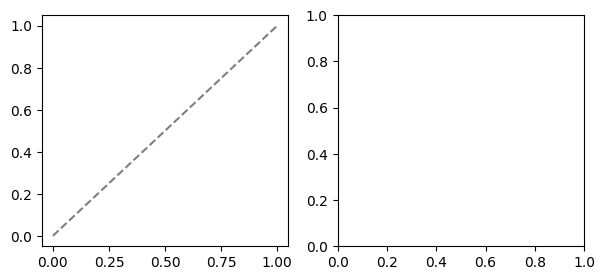

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

ax = axs[0]
ax.plot([0, 1], [0, 1], '--', label="Random", color="tab:grey")

ROC_ALPHA = 0.8


for ptype in POISON_TYPES:
    fpr, tpr = get_rates(ptype)
    ax.plot(fpr.values(), tpr.values(), label=ptype[:10], alpha=ROC_ALPHA)

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
#ax.set_ylim((-0.01, 1.01))
#ax.set_xlim((-0.01, 1.01))
ax.legend()

ax = axs[1]
ax.plot()
ax.set_ylabel("AUROC")
ax.set_xlabel("Poison type")
ax.set_ylim((0, 1))
ax.set_xticklabels([""])
ax.set_xticks([])

plt.tight_layout()
plt.savefig(figdir + "backdoors_roc.pdf", bbox_inches="tight")

### Comparison to CTC

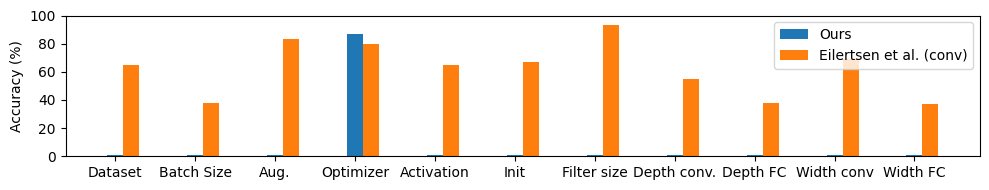

In [ ]:
# first, remake ctc bar chart by copying their results by hand. then, next to every bar put our own results

ctc_conv_results = {
    "Dataset": 65,
    "Batch Size": 38,
    "Aug.": 83,
    "Optimizer": 79.5,
    "Activation": 65,
    "Init": 67,
    "Filter size": 93,
    "Depth conv.": 55,
    "Depth FC": 38,
    "Width conv": 69,
    "Width FC": 37,
}


our_results = {
    "Dataset": 1,
    "Batch Size": 1,
    "Aug.": 1,
    "Optimizer": 87,
    "Activation": 1,
    "Init": 1,
    "Filter size": 1,
    "Depth conv.": 1,
    "Depth FC": 1,
    "Width conv": 1,
    "Width FC": 1,
}

plt.figure(figsize=(10, 2.))
group_positions = np.arange(len(ctc_conv_results.keys()))
group_labels = ctc_conv_results.keys()


bar_width = 0.2
ax = plt.gca()
ax.bar(group_positions, our_results.values(), width=bar_width, label="Ours")
ax.bar(group_positions+bar_width, ctc_conv_results.values(), width=bar_width, label="Eilertsen et al. (conv)")
ax.set_xticks(group_positions)
ax.set_xticklabels(group_labels)
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 100)
ax.legend()

plt.tight_layout()

figpath = "../../writeups/iclr-2023/figures/ctc-comparison.pdf"
plt.savefig(figpath, bbox_inches="tight")